[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO26 Instance Segmentation on a Custom Dataset

---

[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolo26-instance-segmentation-custom-data/) [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO26 introduces a unified architecture designed to support detection, segmentation, and pose tasks within a single model family. The model uses an anchor-free design with a decoupled head.

## Setup

### Configure API keys

To fine-tune YOLO26, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jan 14 20:02:10 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install YOLO26 requirements

In [3]:
%pip install -q "ultralytics>=8.4.0" supervision roboflow

# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.4.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.9/235.7 GB disk)


### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [4]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [5]:
!yolo task=segment mode=predict model=yolo26m-seg.pt source={HOME}/dog-3.jpeg save=True verbose=False

Ultralytics 8.4.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26m-seg summary (fused): 149 layers, 23,569,148 parameters, 0 gradients, 121.5 GFLOPs
Results saved to /content/runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

In [6]:
!ls -la {HOME}/runs/segment/predict/

total 452
drwxr-xr-x 2 root root   4096 Jan 14 20:02 .
drwxr-xr-x 3 root root   4096 Jan 14 20:02 ..
-rw-r--r-- 1 root root 454134 Jan 14 20:02 dog-3.jpg


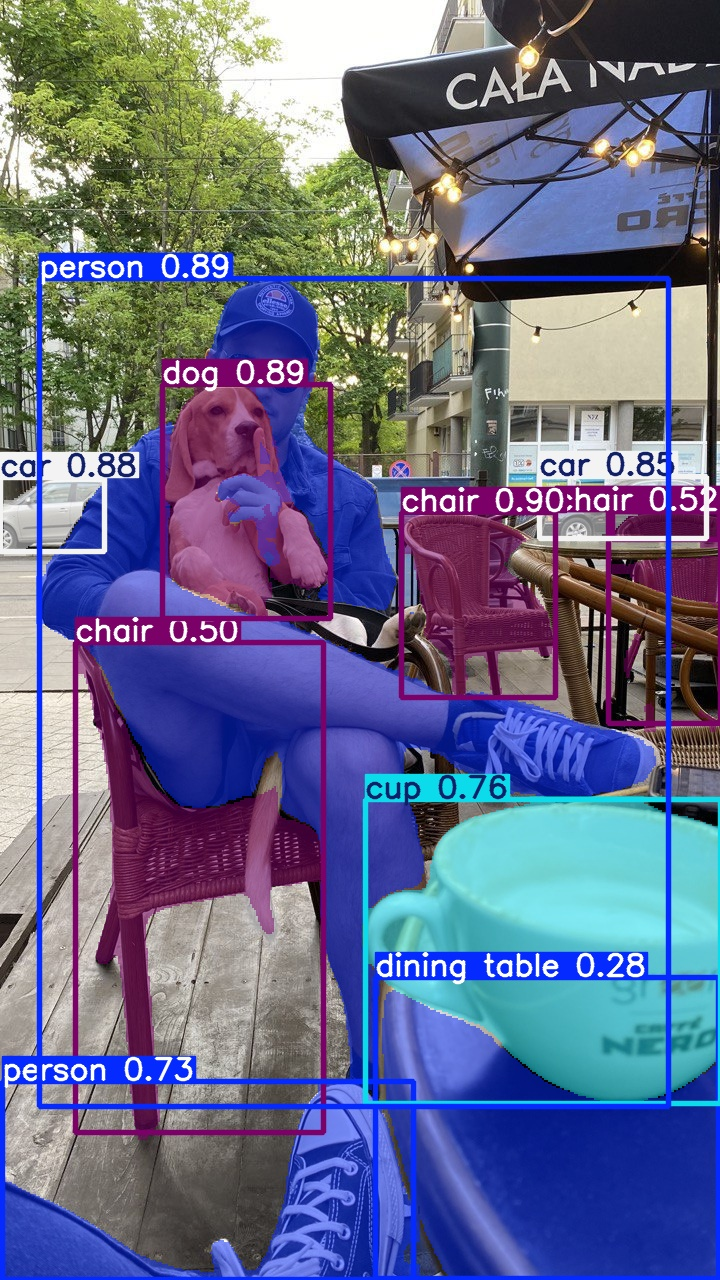

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/predict/dog-3.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [8]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo26m-seg.pt')
image = Image.open(f'{HOME}/dog-3.jpeg')
result = model.predict(image, verbose=False)[0]

**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [9]:
result.boxes.xyxy

tensor([[4.0182e+02, 5.1232e+02, 5.5529e+02, 6.9761e+02],
        [3.9843e+01, 2.7866e+02, 6.6899e+02, 1.1064e+03],
        [1.6295e+02, 3.8428e+02, 3.3045e+02, 6.1896e+02],
        [1.1827e-01, 4.7719e+02, 1.0477e+02, 5.5199e+02],
        [5.3914e+02, 4.7685e+02, 7.0694e+02, 5.3834e+02],
        [3.6556e+02, 7.9963e+02, 7.2000e+02, 1.1036e+03],
        [2.1371e+00, 1.0812e+03, 4.1310e+02, 1.2793e+03],
        [6.1278e+02, 5.1156e+02, 7.1909e+02, 5.3960e+02],
        [7.5835e+01, 6.4234e+02, 3.2344e+02, 1.1328e+03],
        [6.0898e+02, 5.1196e+02, 7.2000e+02, 7.2374e+02],
        [3.7518e+02, 9.7783e+02, 7.1856e+02, 1.2789e+03]], device='cuda:0')

In [10]:
result.boxes.conf

tensor([0.8982, 0.8916, 0.8912, 0.8809, 0.8510, 0.7554, 0.7347, 0.5185, 0.5021, 0.3332, 0.2773], device='cuda:0')

In [11]:
result.boxes.cls

tensor([56.,  0., 16.,  2.,  2., 41.,  0., 56., 56., 56., 60.], device='cuda:0')

In [12]:
result.masks.data.shape

torch.Size([11, 640, 384])

**NOTE:** YOLO26 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [13]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [14]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator()
    polygon_annotator = sv.PolygonAnnotator(color=sv.Color.WHITE)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_position=sv.Position.CENTER_OF_MASS
    )

    out = image.copy()
    out = mask_annotator.annotate(out, detections)
    out = polygon_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections)
    out.thumbnail((1000, 1000))
    return out

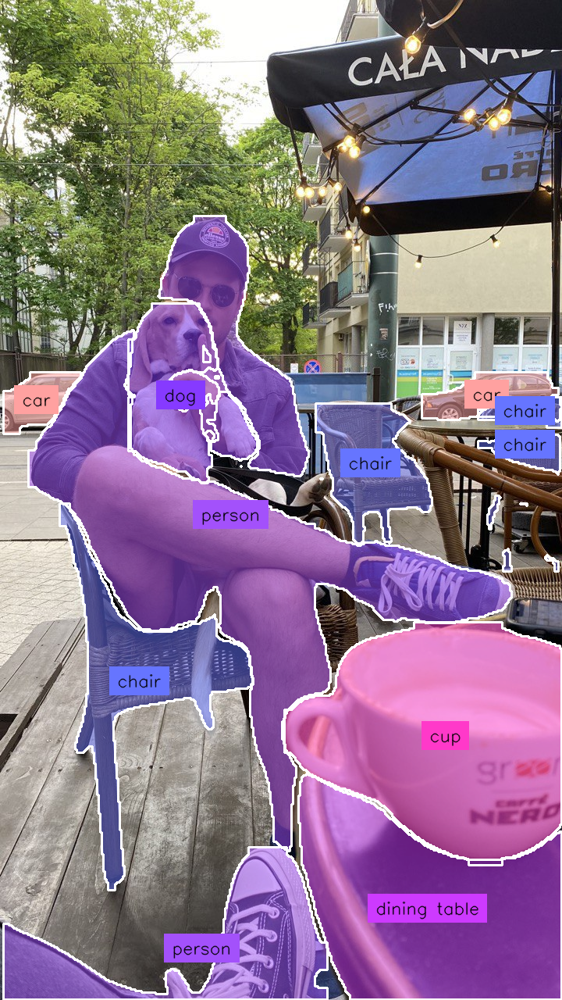

In [15]:
annotated_image = annotate(image, detections)
annotated_image

## Fine-tune YOLO26 on custom dataset

**NOTE:** When training YOLO26, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [16]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("car-damaged-detection-e66m0")
project = workspace.project("car-part-detection-with-damage-part")
version = project.version(2)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Car-Part-Detection-with-Damage-Part-2 in yolov11:: 100%|██████████| 2008/2008 [00:00<00:00, 5337.58it/s]


## Custom Training

In [17]:
%cd {HOME}

!yolo task=segment mode=train model=yolo26m-seg.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

/content
Ultralytics 8.4.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/Car-Part-Detection-with-Damage-Part-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [18]:
!ls {HOME}/runs/segment/train/

args.yaml			 MaskP_curve.png     train_batch441.jpg
BoxF1_curve.png			 MaskPR_curve.png    train_batch442.jpg
BoxP_curve.png			 MaskR_curve.png     val_batch0_labels.jpg
BoxPR_curve.png			 results.csv	     val_batch0_pred.jpg
BoxR_curve.png			 results.png	     val_batch1_labels.jpg
confusion_matrix_normalized.png  train_batch0.jpg    val_batch1_pred.jpg
confusion_matrix.png		 train_batch1.jpg    val_batch2_labels.jpg
labels.jpg			 train_batch2.jpg    val_batch2_pred.jpg
MaskF1_curve.png		 train_batch440.jpg  weights


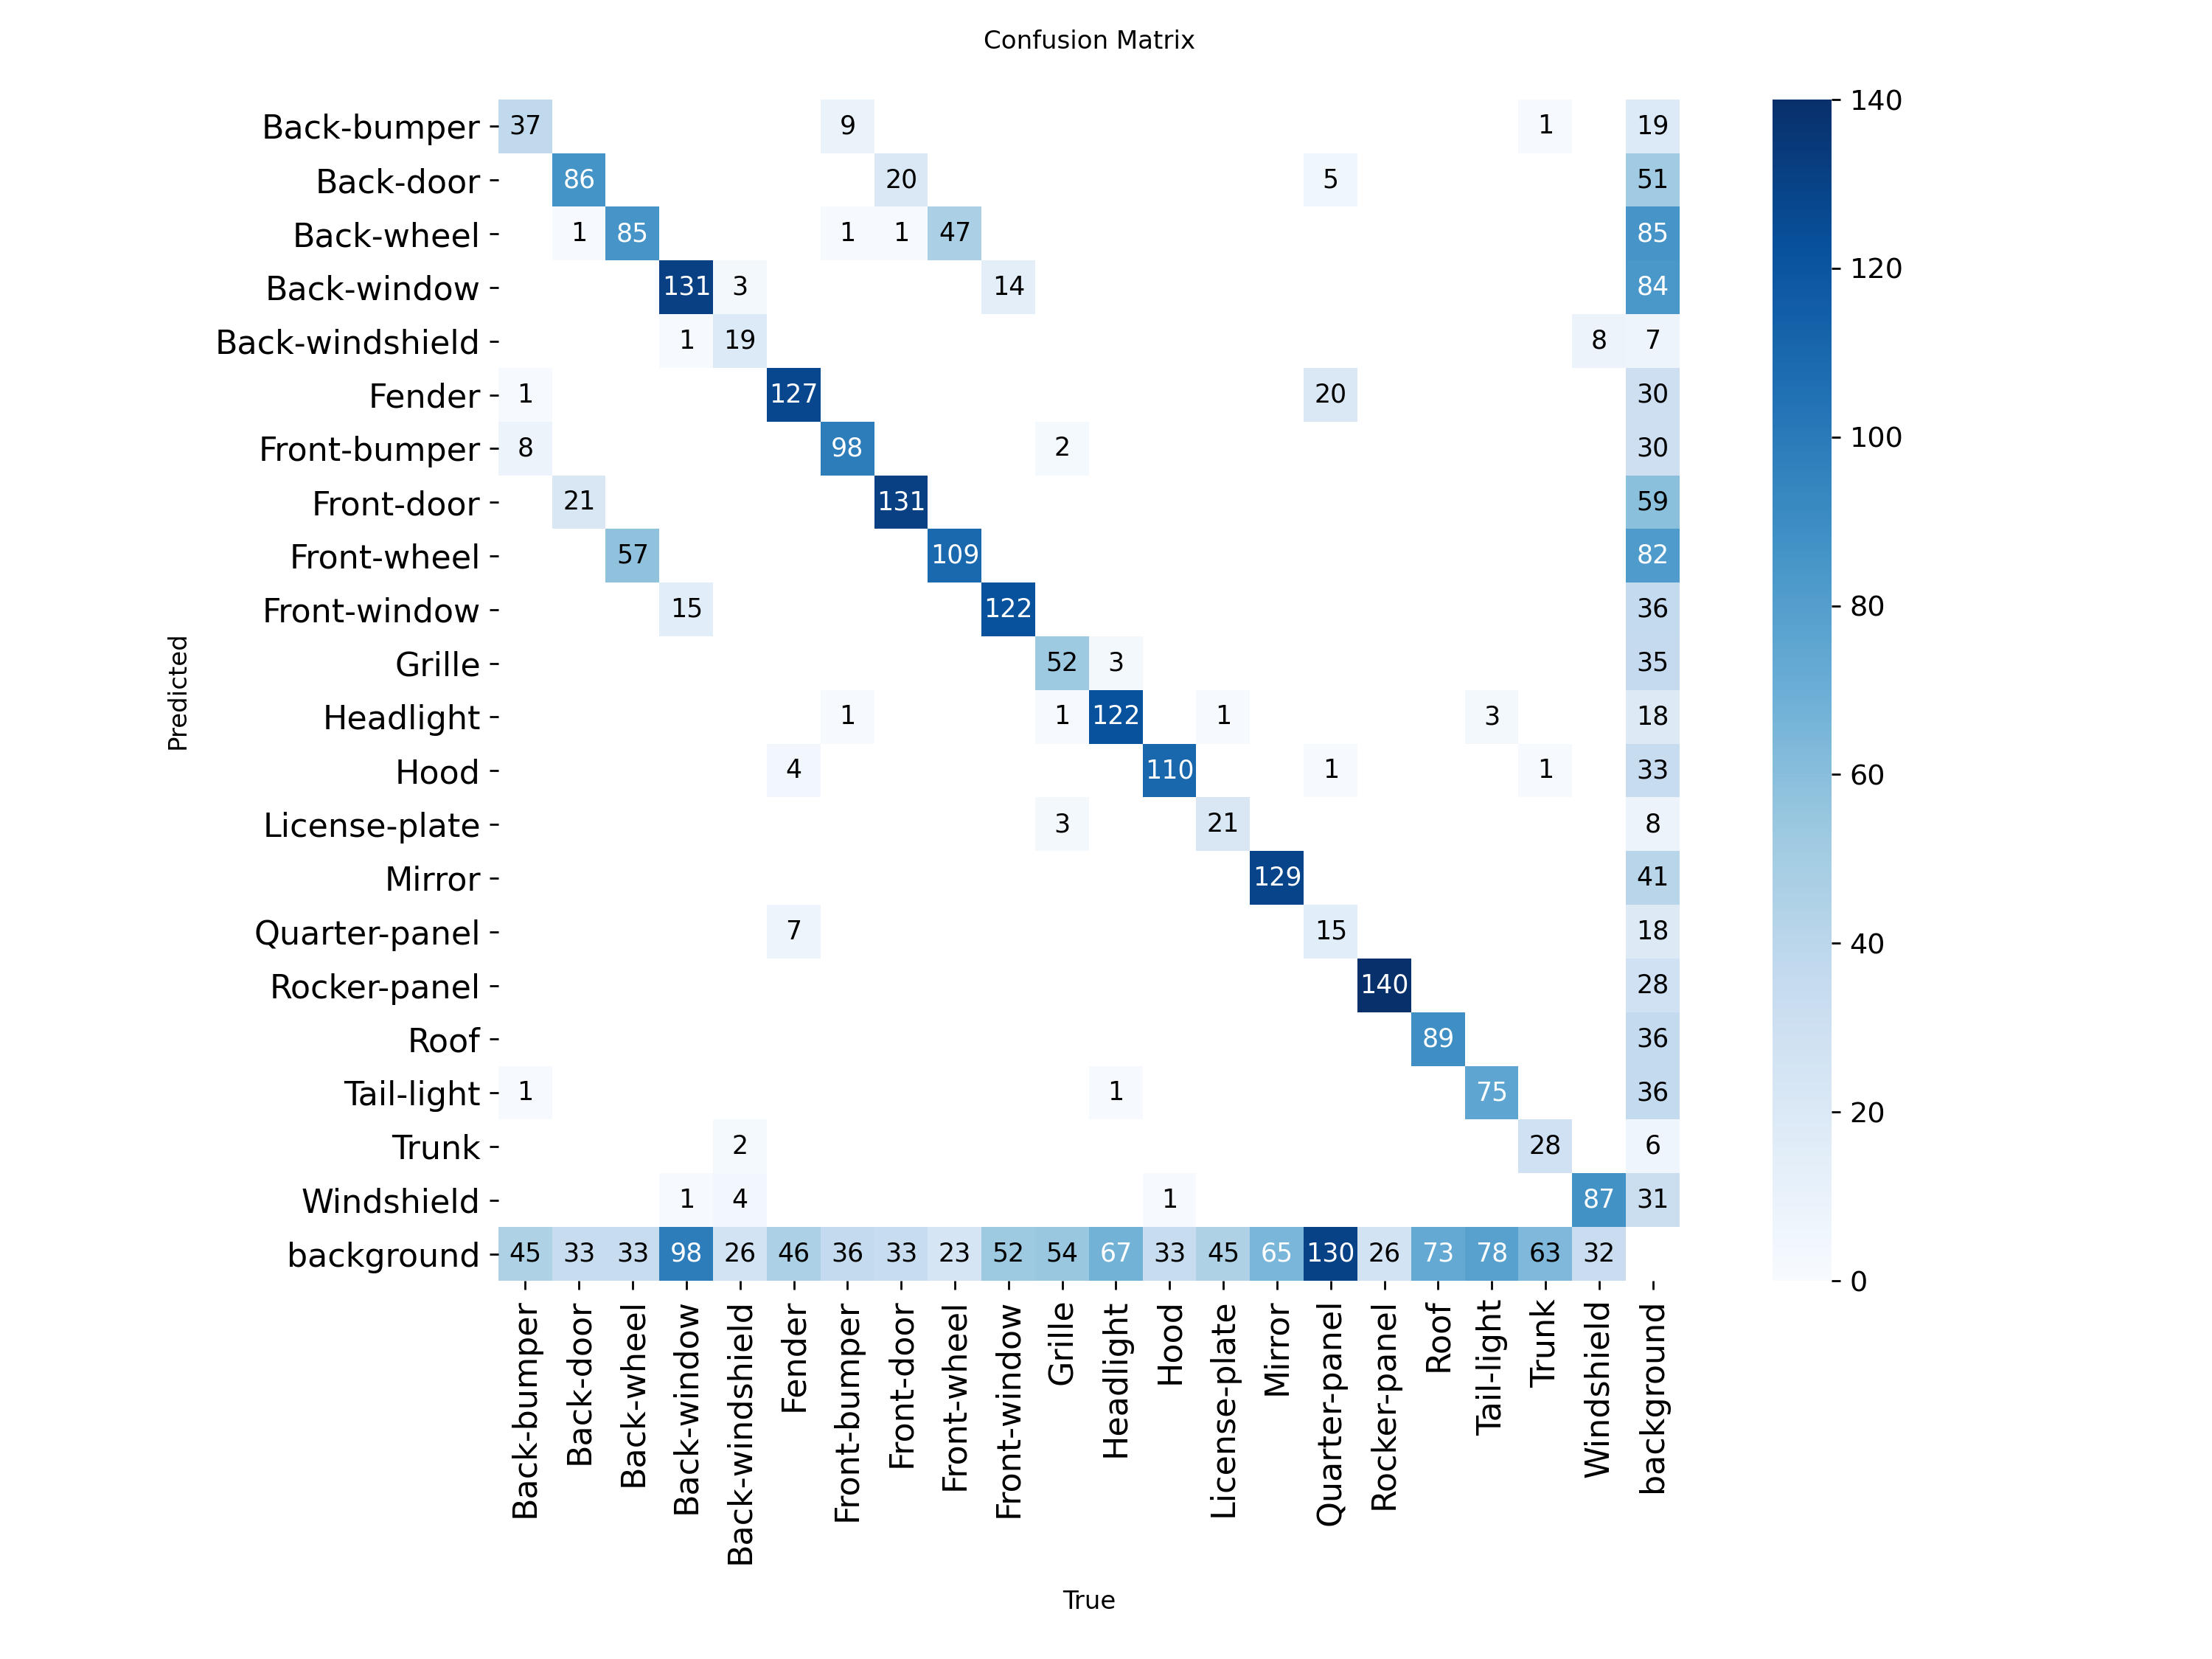

In [19]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

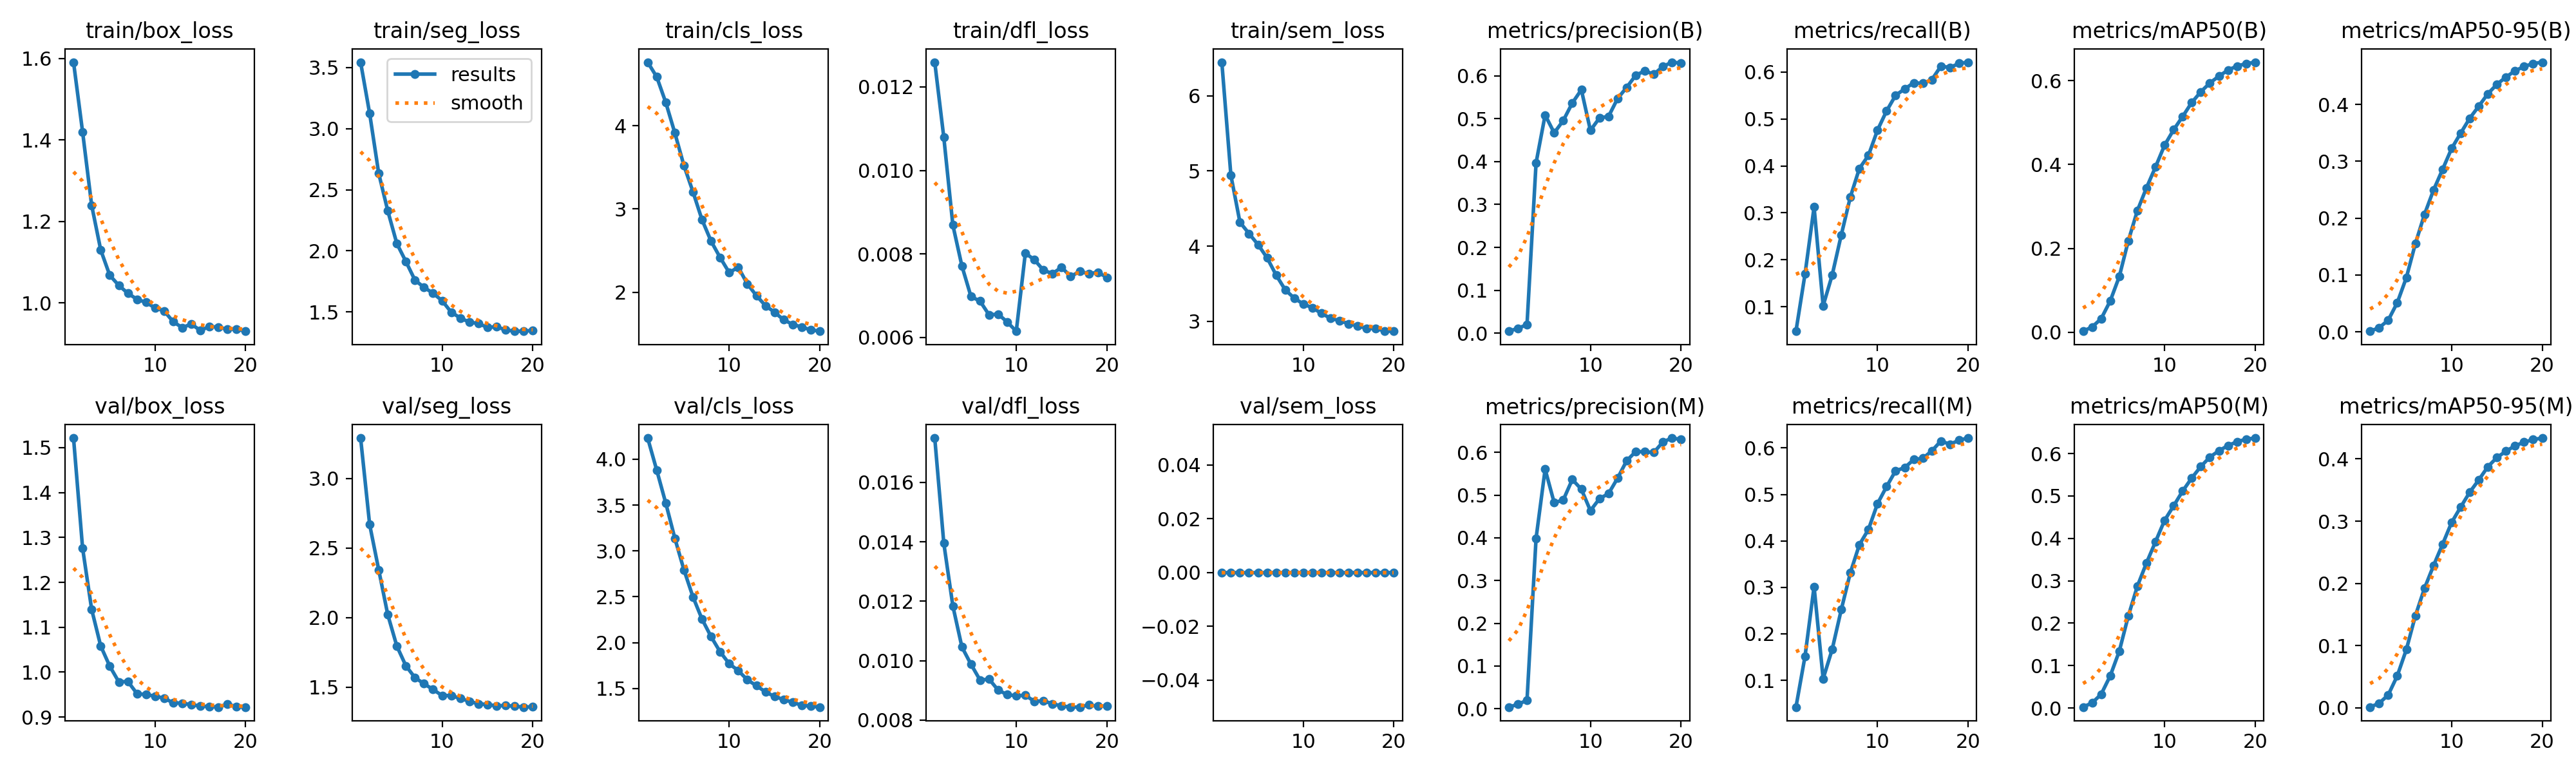

In [20]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=600)

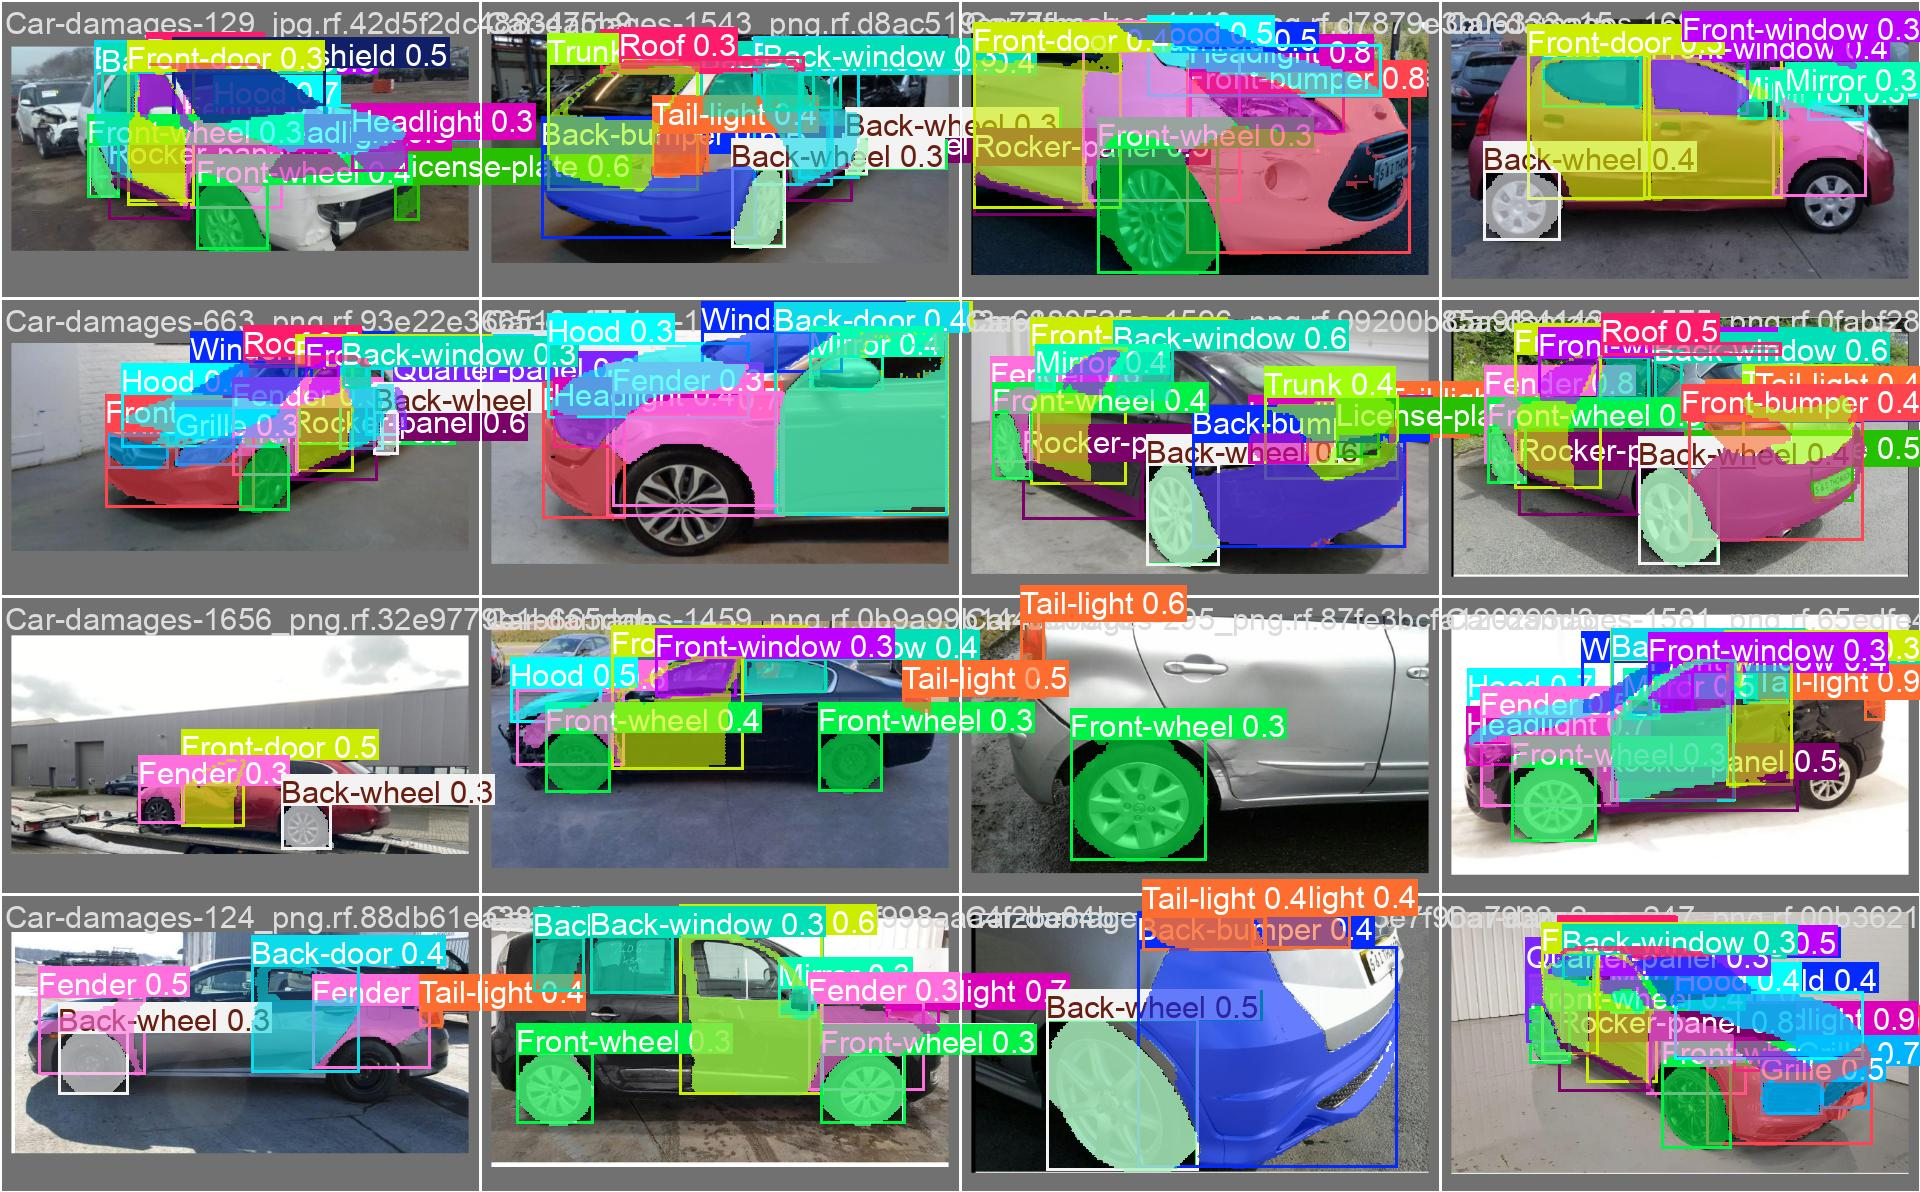

In [21]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [22]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.4.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26m-seg summary (fused): 149 layers, 23,523,659 parameters, 0 gradients, 121.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2109.6±582.1 MB/s, size: 64.6 KB)
val: Scanning /content/datasets/Car-Part-Detection-with-Damage-Part-2/valid/labels.cache... 199 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 199/199 39.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 1.2it/s 10.4s
                   all        199       3174      0.636      0.615      0.643      0.474      0.637      0.611      0.636      0.433
           Back-bumper         92         92       0.58      0.489      0.513      0.437      0.554      0.467      0.473      0.398
             Back-door        140        141      0.548      0.713      0.624      0.504      0.531      0.691      0.603      0.363
   

## Inference with custom model

### CLI

In [23]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt source={dataset.location}/test/images save=True verbose=False

Ultralytics 8.4.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26m-seg summary (fused): 149 layers, 23,523,659 parameters, 0 gradients, 121.3 GFLOPs
Results saved to /content/runs/segment/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


### SDK

In [24]:
from ultralytics import YOLO

model = YOLO(f'{HOME}/runs/segment/train/weights/best.pt')

In [25]:
import supervision as sv

ds_test = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
    force_masks=True
)

In [28]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
    color = sv.ColorPalette.from_hex([
        "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00",
        "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    ])

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator()
    polygon_annotator = sv.PolygonAnnotator(color=sv.Color.WHITE)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_position=sv.Position.CENTER_OF_MASS
    )

    out = image.copy()
    out = mask_annotator.annotate(out, detections)
    out = polygon_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections)
    out.thumbnail((1000, 1000))
    return out

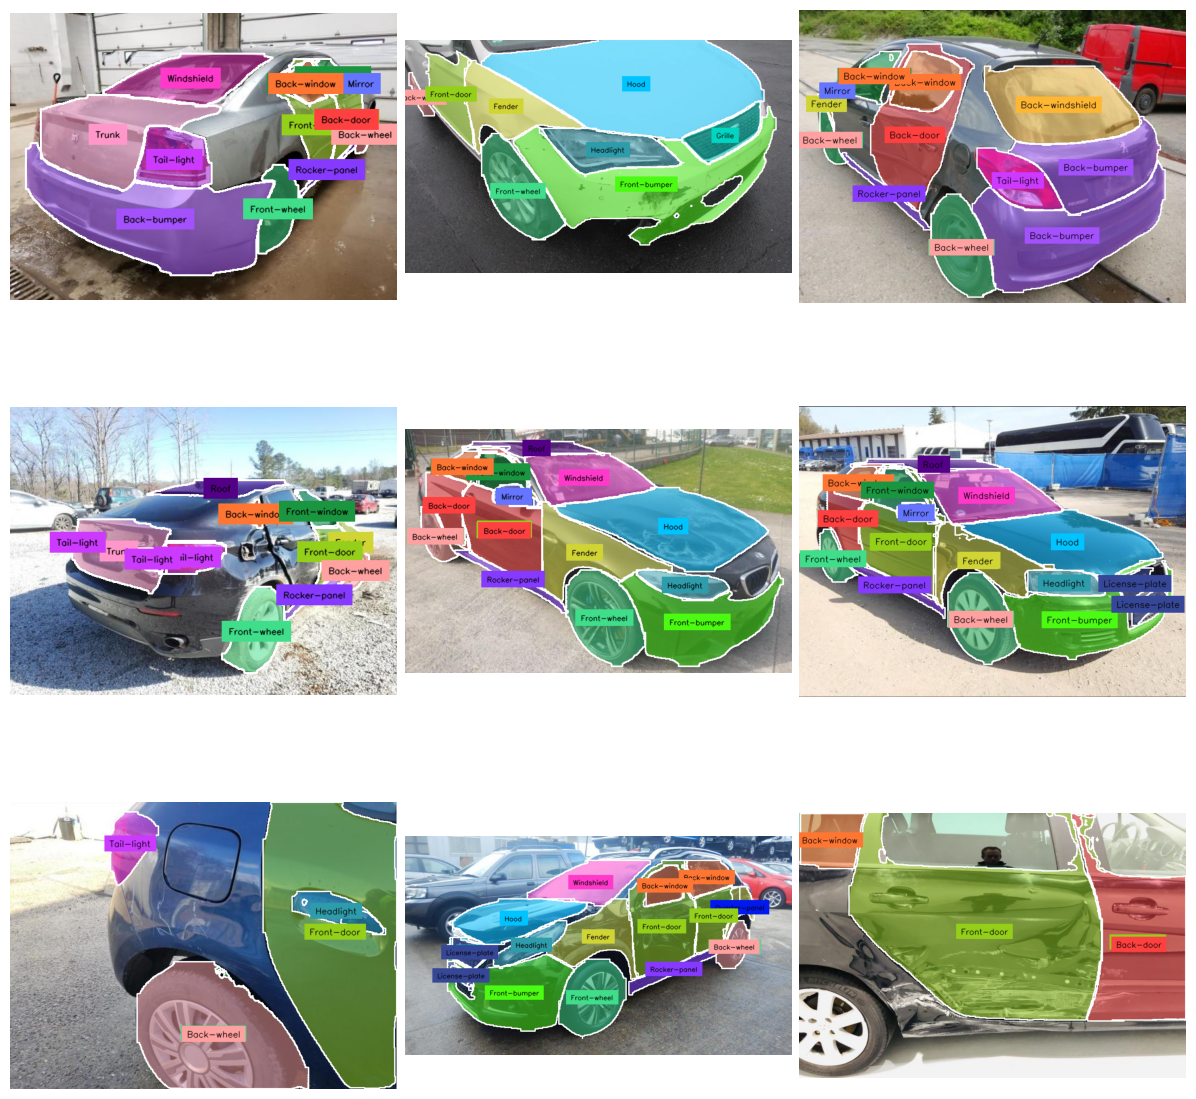

In [29]:
import random
import matplotlib.pyplot as plt

N = 9
L = len(ds_test)

annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds_test[i]
    image = Image.open(path)
    result = model.predict(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)
    annotated_image = annotate(image, detections)
    annotated_images.append(annotated_image)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)

plt.show()

## Deploy model on Roboflow

Roboflow upload support for YOLO26 is coming soon. Stay tuned for updates!

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>